# Problem 1
## Feedforward Neural Network for Classication

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import math
import argparse

In [11]:
# read data
train_data = np.load('train.npz') 
test_data = np.load('test.npz')

x_train = np.array([i.ravel() for i in (train_data['image'] / 255)]) # 51000*1024
y_train = train_data['label']

x_test = np.array([i.ravel() for i in (test_data['image'] / 255)]) #7954*1024
y_test = test_data['label']

In [12]:
class FNN():
    
     def __init__(self, batch_size, act, layer, weights = 0.1, epoch = 20, iteration = 25, learning_rate = 0.001):
        self.epoch = epoch
        self.iteration = iteration
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.act = act
        self.layer = layer
        self.weights = self.weight_init(layer, weights)
    
     def weight_init(self,nn, weights):
        layer = {}
        num = 0
        
        if weights == 0.1:
            for i in nn.values():
                w = 0.1 * np.random.randn(i['input_dim'], i['output_dim'])
                layer[num] = w
                num += 1
        elif weights == 0:
            for i in nn.values():
                w = np.zeros((i['input_dim'], i['output_dim']))
                layer[num] = w
                num += 1
        else:
            for i in weights.values():
                layer[num] = 0.1 * i
                num += 1
                
        return layer
    
     def predict(self, x): 
        predict_a, predict_z = self.forward(x)
        y = np.argmax(predict_a[-1], axis = 1)
        return y
     
     def forward(self, train):
        z = []
        a = []
        for i in range(len(self.weights)):
            zz = 0
            if i == 0:
                #print('layer0:', train.shape, self.weights[i].shape)
                zz = np.nan_to_num(np.dot(train, self.weights[i]))
                z.append(zz)
            else:
                #print('layer%s'%i,np.array(a[-1]).shape, self.weights[i].shape)
                zz = np.nan_to_num(np.dot(a[-1], self.weights[i]))
                z.append(zz)
                
            if self.act[i] == 'relu':
                #print('layer%s: relu'%i)
                aa = self.relu(zz)
                a.append(aa)
                #print(aa)
            else:
                #print('layer%s: softmax'%i)
                aa = self.softmax(zz)
                a.append(aa)
                #print(aa)
            
        return a, z
    
     # leabl one hot encoding
     def one_hot(self, label):
        onehot_encoded = np.eye(self.layer["output"]["output_dim"])[np.array(label).reshape(-1)]
        return onehot_encoded
    
     # activation function
     def relu(self, a):
        return np.maximum(0, a)
    
     def relu_derivative(self, a):
        relu = lambda x : 1 if x > 0 else 0
        drelu = np.vectorize(relu)(a)
        return drelu
    
     def softmax(self, a):
        exps = np.exp(a - np.max(a ,axis = 1).reshape(-1,1))
        return exps / np.sum(exps,axis = 1)[:, None]
    
     # loss function
     def cross_entropy(self, test, predict):
        return np.mean(-np.sum(test * np.log(predict + 1e-8), axis=1))
    
     # accuracy
     def accuracy(self, test, predict):
        predict_lebel = np.argmax(predict, axis = 1)
        return np.sum((predict_lebel == test) / len(test))
    
     def backward(self, t, a, N, x, z):
        delta = []
        last_a = []
        
        for i in range(len(self.weights) - 1,-1,-1):
            #print('gradient w%s' %i)
            if i == (len(self.weights) - 1): # output layer
                delta = a[-1] - t
            else: # hiddlen layer
                f = self.relu_derivative(z[i])
                last_delta = np.dot(delta, self.weights[i + 1].transpose())
                delta = np.multiply(last_delta, f)
            
            if i == 0:
                last_a = x.transpose()
            else:
                last_a = a[i - 1].transpose()
    
            dw = np.dot(last_a, delta)
            self.weights[i] = self.weights[i] - self.learning_rate / N * dw
            #print(w[i])
   
     def gradient(self, x, y):   
        loss_list = []
        acc_list = []
        for ep in range(self.epoch):
            #print('---------------epoch%s----------'%ep)
            for it in range(self.iteration): 
                #print('---------------iteration%s---------------'%it)
                # batch
                x_batch = x[self.batch_size * it : self.batch_size * (it + 1)]
                y_batch = y[self.batch_size * it : self.batch_size * (it + 1)]
                
                #print('\nforward')
                # forward
                forward_output, z = self.forward(x_batch)
                on_hot_lebel = self.one_hot(y_batch)
                
                # loss function
                loss = self.cross_entropy(on_hot_lebel, forward_output[-1])  
                loss_list.append(loss)
                
                # accuarcy
                acc = self.accuracy(y_batch, forward_output[-1])
                acc_list.append(acc)
                
                #print('\nbackward')
                # backward
                self.backward(on_hot_lebel, forward_output, len(x_batch), x_batch, z)    
           
        #print(loss_list)
        #print(acc_list)
        return loss_list, acc_list

In [27]:
# plot
def plot(train_loss, train_acc, test_loss, test_acc):
    plt.title("learning curves of J(w)")
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
    plt.title("accuracy of classification")
    plt.plot(train_acc, label='train accuracy')
    plt.plot(test_acc, label='test accuracy')
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [ ]:
# argparse
parser = argparse.ArgumentParser()
parser.add_argument("--config", help = "set config")
parser.add_argument("--weight", help = "set weight")
parser.add_argument("--imgfilelistname", help = "set imgfilelistname")
args = parser.parse_args()

### 1.(a)-(c)皆是以下列參數為基礎來訓練

"layer1":{
    "input_dim": 1024,
    "output_dim": 2048,
    "act": "relu"
},

"layer2":{
    "input_dim": 2048,
    "output_dim": 512,
    "act": "relu"
},

"output":{
    "input_dim": 512,
    "output_dim": 6,
    "act": "softmax"
}

"epoch": 20,
"lr": 0.001,
"batch_size": 2048,
"criterion": "cross_entropy"


## 1.(a) Plot the learning curves of J(w) and the accuracy of classification

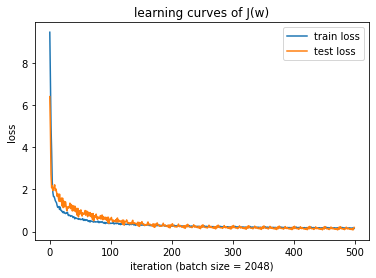

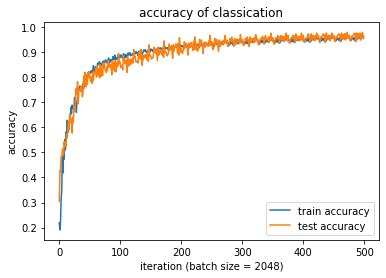

In [5]:
'''
# train
params = json.load(open('config.json',))
network = FNN(epoch = params['epoch'], batch_size = params['batch_size'], layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / params['batch_size'])), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()]))
train_loss, train_acc = network.gradient(x_train, y_train)

# test
network = FNN(epoch = params['epoch'], batch_size = int(len(x_test)/(len(x_train)/params['batch_size'])), layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / params['batch_size'])), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()]))
test_loss, test_acc = network.gradient(x_test, y_test)

# plot
plot(train_loss, train_acc, test_loss, test_acc)
'''

## 1.(b) using different batch sizes
batch sizes = 4096

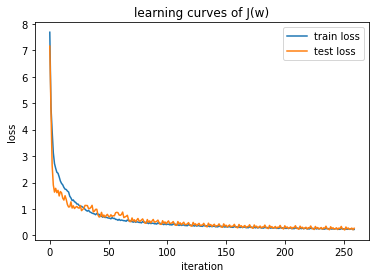

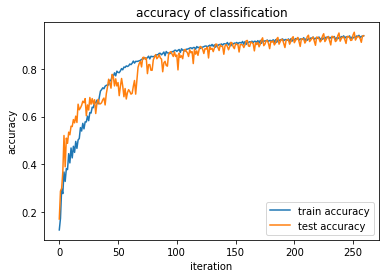

In [28]:
'''
# train
params = json.load(open('config.json',))
network = FNN(epoch = params['epoch'], batch_size = 4096, layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / 4096)), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()]))
train_loss, train_acc = network.gradient(x_train, y_train)

# test
network = FNN(epoch = params['epoch'], batch_size = int(len(x_test)/(len(x_train)/4096)), layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / 4096)), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()]))
test_loss, test_acc = network.gradient(x_test, y_test)

# plot
plot(train_loss, train_acc, test_loss, test_acc)
'''

### discussions

第(a)小題是用2048的batch size，而第(b)小題是用4096的batch size，相較之下，當batch size較大的時候，在一開始可能會產生較大的震盪，但兩者的learning curves並沒有太大差別，皆可以得到較好的收斂狀態。

## 1.(c) zero initialization for the model weights
weights = 0

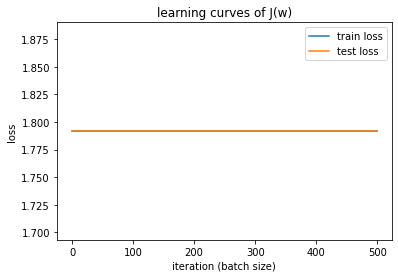

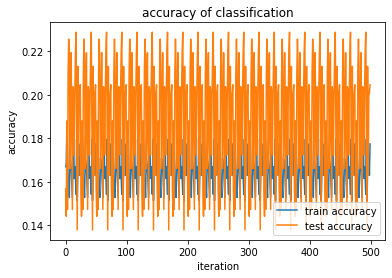

In [20]:
'''
network = FNN(epoch = params['epoch'], batch_size = params['batch_size'], layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / params['batch_size'])), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()])
                            , weights = 0)
train_loss, train_acc = network.gradient(x_train, y_train)

# test
network = FNN(epoch = params['epoch'], batch_size = int(len(x_test)/(len(x_train)/params['batch_size'])), layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / params['batch_size'])), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()])
                            , weights = 0)
test_loss, test_acc = network.gradient(x_test, y_test)

# plot
plot(train_loss, train_acc, test_loss, test_acc)
'''

### discussions

當weight初始為0的情況下，會使得每層的輸出都是相同的，因此當作回backpropagation時，gradient也會相同，所以weight不會更新，會一直是相同數值，因此導致模型無法收斂。

## 2.(a) generate output.txt

In [ ]:
weights_list = np.load(args.weight)
params = json.load(open(args.config))
network = FNN(epoch = params['epoch'], batch_size = params['batch_size'], layer = params['nn']
                            , iteration = int(math.ceil(len(x_train) / params['batch_size'])), learning_rate = params['lr']
                            , act = np.array([params['nn'][i]['act'] for i in params['nn'].keys()])
                            , weights = weights_list)
train_loss, train_acc = network.gradient(x_train, y_train)

image = open(args.imgfilelistname, 'r')
test_image = []
for line in image.readlines():
    img = cv2.imread(line.replace('\n',''), 0)
    test_image.append(img)
    
test_image = np.array([i.ravel() for i in (np.array(test_image) / 255)]) 
predict = (network.predict(test_image))
print('predict label:',predict)

np.savetxt('output.txt', predict, fmt = "%i", newline = "")
print('save in output.txt')